In [30]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = (
    x_train[..., np.newaxis] / 255.0,
    x_test[..., np.newaxis] / 255.0,
)

# Initialise and summarise the fully-CNN model

In [ ]:
class SimpleNet(tf.keras.Model):
    def __init__(self, out_dim, **kwargs):
        super(SimpleNet, self).__init__(**kwargs)

        # define network architecture
        self.c1 = Conv2D(filters=16, kernel_size = (3,3), strides = (2,2),
            use_bias=False, padding='same', activation='relu')
        self.c2 = Conv2D(filters=32, kernel_size = (3,3), strides = (2,2),
            use_bias=False, padding='same', activation='relu')
        #self.dense = Dense(10)
        self.dense = Conv2D(filters=out_dim, kernel_size=(7,7))
        self.flatten = Flatten()

    def call(self, inputs: tf.Tensor, softmax: bool = True):
        X = self.c1(inputs)
        X = self.c2(X)
        X = self.dense(X)
        X = self.flatten(X)
        return tf.nn.softmax(X) if softmax else X

In [3]:
model = SimpleNet(out_dim=10)
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Build (by specifying input_shape) and summarize model
mb_size = 32
input_shape = [mb_size] + list(x_train.shape[1:])
model.build(input_shape)
model.summary()

Model: "simple_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  144       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4608      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  15690     
_________________________________________________________________
flatten (Flatten)            multiple                  0         
Total params: 20,442
Trainable params: 20,442
Non-trainable params: 0
_________________________________________________________________


# Train model

In [4]:
model.fit(x=x_train,y=y_train,batch_size=32,epochs=5,validation_data=(x_test, y_test),shuffle=True)

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4500 - sparse_categorical_accuracy: 0.8732 - val_loss: 0.1056 - val_sparse_categorical_accuracy: 0.9663
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1036 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.0684 - val_sparse_categorical_accuracy: 0.9795
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0759 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0584 - val_sparse_categorical_accuracy: 0.9810
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0657 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.0595 - val_sparse_categorical_accuracy: 0.9824
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0516 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.0548 - val_sparse_categorical_accuracy: 0.9810



# Make a prediction and calculate saliency map for an example input

In [5]:
ind_exmp = 0
pred = model(x_test[None,ind_exmp])
target = y_test[ind_exmp]
pred_cat = np.argmax(pred)

score = pred.numpy()[0,pred_cat]
print(np.around(pred.numpy(),decimals=2))
print("Target category: {}, Predicted category: {} with score (pseudo-probability): {:.2f}"\
      .format(target,pred_cat,score))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Target category: 7, Predicted category: 7 with score (pseudo-probability): 1.00


In [27]:
idx = 100
exmp_inp = tf.Variable(x_test[None,idx], dtype=float) # make tf.var so that grads can be recorded

with tf.GradientTape() as tape:
    pred = model(inputs=exmp_inp,softmax=False)
    score = tf.reduce_max(pred)
    #score = pred[0,tf.math.argmax(pred[0])]
    
grads = tape.gradient(score, exmp_inp)
print(grads.shape, type(grads))

(1, 28, 28, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>


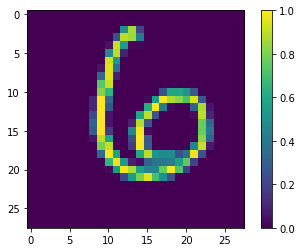

In [7]:
plt.imshow(x_test[idx, :, :, 0])#,cmap='gray')
plt.colorbar()

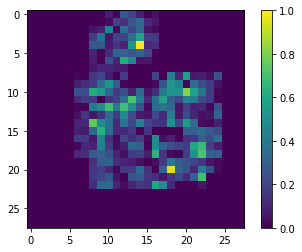

In [8]:
grad_img = np.abs(grads.numpy()[0, :, :, 0])
grad_img /= np.max(grad_img)
plt.imshow(grad_img)#,cmap='gray')
plt.colorbar()

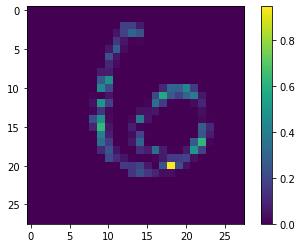

In [9]:
# hadamard product between input image and gradient image
plt.imshow(grad_img*x_test[idx, :, :, 0])#,cmap='gray')
plt.colorbar()

# Aggregate saliency maps for all examples from a single class

In [10]:
class_num = 6
indecies = np.where(y_test==class_num)

x_test_c, y_test_c = x_test[indecies], y_test[indecies]
x_test_c.shape, y_test_c.shape

((958, 28, 28, 1), (958,))

In [35]:
# Could not find a batch-wise tape gradient. This is prolly coz loss is usually aggregrated to one dimension
# Result: have to backpropagate (wrt. input) for each input

tot_grads=[]
for i in tqdm.trange(x_test_c.shape[0]):
    with tf.GradientTape() as tape:
        tmp = tf.Variable(x_test_c[None,i], dtype=float)
        pred = model(inputs=tmp,softmax=False)
        score = tf.reduce_max(pred) # predicted class
        #score = pred[class_num] # label class
    
    tot_grads.append(tape.gradient(score, tmp)[0])
    
tot_grads = tf.stack(tot_grads)
print(tot_grads.shape)

100%|██████████| 958/958 [00:04<00:00, 207.22it/s]

(958, 28, 28, 1)


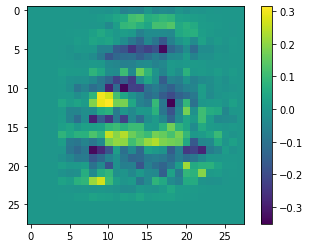

In [36]:
aggregated_grads = np.mean(tot_grads.numpy(),axis=0)[...,0]


#grad_img = np.abs(tot_grads.numpy()[0, :, :, 0])
#grad_img /= np.max(grad_img)
plt.imshow(aggregated_grads)#,cmap='gray')
plt.colorbar()